# Inverse kinematics
This notebook considers the problem of inverse kinematics, ie solving at each control cycle of the robot a quadratic program from the derivatives (jacobian) of the current state. It introduces the basic function to compute the Jacobians of the robot, and how to use them to compute an inverse-kinematics control law. One of the key difficulties is to understand in which frames each quantities is computed (this might be in the world frame, in the local frame attached to the end-effector, in some arbitrary goal frame, etc), as we should never mix quantities expressed in different frames. 


In [24]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up
Let us import the standard libraries for the tutorials and load a new robot

In [1]:
# %load tp3/generated/inverse_kinematics_import
import pinocchio as pin
import numpy as np
import time
from numpy.linalg import pinv,inv,norm,svd,eig
from tp3.tiago_loader import loadTiago
import matplotlib.pylab as plt
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import unittest


We will use the Tiago robot (https://youtu.be/6BwRqwD066g). This mobile manipulator from PAL Robotics as a mobile basis which can move in the plane (3 degrees of freedom or dof), a manipulator arm (7 dof) and a head (2 dof) both mounted on a prismatic axis moving vertically (1 dof). This makes 3 dof for the basis, and 9 dof for the body. It also has 2 extra joints tot figure the wheels, which are not very useful for this notebook. The wheels and the basis rotations are represented by the cos and sin of the angle. The size of the configuration vector is then 18, while the velocity vector has dimension 15.

A load function is available to make it easy to load the robot.

In [2]:
# %load tp3/generated/inverse_kinematics_robot
robot = loadTiago()
viz = MeshcatVisualizer(robot)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
viz.viewer.jupyter_cell()

The configuration is represented by a vector of larger dimension, subject to constraints (cos^2+sin^2=1). It is not possible to randomly sample a configuration vector q, as these constraints should be respected. Similarly, we should take care when integrating a velocity as summing a configuration q with a velocity v will not work (dimensions do not match). Two functions in Pinocchio implements these functionnalities.

In [7]:
q = pin.randomConfiguration(robot.model)
vq = np.random.rand(robot.model.nv)*2-1
DT = 1e-2
qnext = pin.integrate(robot.model,q,vq*DT)

A simple example moving the robot in the viewer following a constant (random) velocity is as follows.

In [30]:
for t in range(1000):
    q = pin.integrate(robot.model,q,vq*DT)
    viz.display(q)
    time.sleep(DT/10)

The robot is mobile, hence the camera view in the viewer is not always centered. You can also see here that respecting joint limits might be a good idea!

## Forward kinematics and Jacobian
We recall first the basic method to compute the robot forward kinematics.
We will consider two frames of interest on the robot: the first one, named <tool> is at the tip of the end-effector ; the second one, named <basis>, is on the front of the robot basis, 10 cm above the ground. Both are represented in Gepetto-Viewer by a frame composed of three RGB arrows. 

In [31]:
# %load tp3/generated/inverse_kinematics_frames
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')


In [32]:
robot.model.frames[IDX_TOOL]

Frame name: frametool paired to (parent joint/ previous frame)(9/52)
with relative placement wrt parent joint:
  R =
1 0 0
0 1 0
0 0 1
  p =    0    0 0.08
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0

### Computing frame placement
These frames are computed by the Pinocchio function framesForwardKinematics, whose results are stored in robot.data.oMf.     

In [33]:
pin.framesForwardKinematics(robot.model,robot.data,q)
print("Tool placement:",robot.data.oMf[IDX_TOOL])
print("Basis placement:",robot.data.oMf[IDX_BASIS])

Tool placement:   R =
 0.304543   0.77049  0.559999
 0.506457 -0.628916  0.589886
 0.806694   0.10397 -0.581752
  p =  0.75067 0.178881 0.575667

Basis placement:   R =
1 0 0
0 1 0
0 0 1
  p =  0.3    0 0.15



It is very important to notice the instruction pattern (which is standard in all Pinocchio functions): first call a whole-body algorithm (here *pin.framesForwardKinematics*), then access the results into *robot.data*. 

The tool-placement matrix oMtool represents the displacement from the world frame F_o to the tool frame F_tool. It is composed on a rotation matrix oRtool and a 3D vector o_OT: oMf = [ oRf o_OT ], when o_OT is the vector from the origin of frame F_o to the origin of from F_tool ; this vector is expressed in the world frame F_o. We can instead express OT in the tool frame F_tool by multiplying it by oRtool:

In [34]:
oMtool = robot.data.oMf[IDX_TOOL]
oRtool = oMtool.rotation; o_OT = oMtool.translation
tool_OT = oRtool.T @ o_OT

Beware of the multiplication operator in numpy. The operator* is (unintuitively) mapped to the coefficient-wise multiplication ... i.e. not at all the matrix multiplication. You should use the operator @ to get the real matrix-matrix product. 
Never mind, you will likely be tricked at least once by this design pattern. If you don't like it ... well there is nothing to do, this is the basic matrix library in Python, the world most used language. 

### Computing Jacobians
The jacobian of a frame of the robot is computed using pin.computeFrameJacobian.

In [35]:
Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
Jtool.shape

(6, 15)

This matrix has 6 rows and NV=15 columns. It corresponds to the "spatial" 6D velocity of the end effector. Let's first focus on the 3 first rows, corresponding to the linear velocity.

In [36]:
Jtool3 = Jtool[:3,:]

#### Jacobian as a velocity operator
A first way to understand what is this matrix is to see that as an operator that converts the velocity in the configuration space into the linear velocity of the end effector.

In [37]:
vtool = Jtool3 @ vq

But in which frame is vtool expressed? The choice in Pinocchio (following algorithmic principles described in [Featherstone 2009]) is to express quantities in the local frame by default. So vtool is expressed in the tool frame F_tool (or more precisely, the Galilean frame coinciding with F_tool at the current time instant). We would better denote it with its frame.

In [38]:
tool_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
tool_Jtool3 = tool_Jtool[:3,:]
tool_vtool = tool_Jtool3 @ vq

We are using long variable names. In the code, these explicit notations are maybe too much. It is your choice to use them or not. 
The tool velocity is easier to interpret in the world frame.

In [39]:
o_vtool = oRtool @ tool_vtool

We generalise this notation to the jacobian expressed in the world frame F_o:

In [40]:
o_Jtool3 = oRtool @ tool_Jtool3

#### Jacobian as a derivative
A second interpretation to explain what is the jacobian is to observe that it is the derivative of the vector o_OT (the tool position in world frame). Indeed o_OT is a function of q: o_OT(q). We can take its derivative with respect to q, denoted d o_OT / dq. This derivative is equal to the Jacobian expressed in the world frame F_o: d o_OT / dq = o_Jtool.
To be convinced of that, let's check the finite differences. We take a small movement dq, and see that the change in position o_OT(q+dq) corresponds to the linear prediction o_Jtool3*dq.

In [41]:
# Sample between -0.001 and 0.001
EPS = 1e-3
dq = (np.random.rand(robot.model.nv)*2-1)*EPS

# q2 = q+dq
q2 = pin.integrate(robot.model,q,dq)                     
pin.framesForwardKinematics(robot.model,robot.data,q)

# tool position for q
o_OT = robot.data.oMf[IDX_TOOL].translation.copy()

# tool position for q+dq
pin.framesForwardKinematics(robot.model,robot.data,q2)
o_OT2 = robot.data.oMf[IDX_TOOL].translation.copy()

print((o_OT2 - o_OT)/EPS)
print((o_Jtool3@dq/EPS))

[0.23387726 1.25096901 0.41909983]
[0.23411229 1.25114922 0.41903859]


#### Frame options in Pinocchio
Most algorithms accept an option to specify in wich frame the spatial quantity should be expressed. The two basic options are *pin.LOCAL* and *pin.WORLD*. When related to velocity, *LOCAL* is the linear velocity of the center of the local frame (the TOOL_IDX frame, here) and the angular velocity, both expressed in the local frame. With *WORLD* frame, the two velocities are expressed in the world frame ... but remember that the linear velocity is then difficult to interpret.

A last option is given for convenience, which does not respect the mathematics of spatial velocity, but matches the French "torseur cinématique": pin.LOCAL_WORLD_ALIGNED gives the linear velocity of the center of the local frame and the angular velocity, both expressed in the world frame. It is convenient especially when we are interested in considering the linear velocity as the derivative of the position.

In [42]:
o_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL,
                                   pin.LOCAL_WORLD_ALIGNED)[:3,:]

You can watch this video which explain with more illustrations the 3 frame options:  https://youtu.be/MLFtHLTprE4 

#### Jacobian in 6D
The jacobian of the frame indeed has 6 rows, and corresponds to the spatial velocity of the frame. It is expressed locally, in the tool frame (or more precisely the Galilean frame coincinding with the tool frame to the current time instant).

In [43]:
tool_J = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
tool_nu = tool_J @ vq

We denote by nu the spatial velocity. It is composed by the linear velocity of the center of the frame vtool and the angular velocity of the tool frame, both expressed in the tool frame: tool_nu = [ tool_vtool, tool_w ].



In [44]:
tool_vtool = tool_nu[:3] ; tool_w = tool_nu[3:]

We can instead express the spatial velocity in the world frame F_o by multiplying it by the so-called action matrix oXtool.

In [45]:
o_nu = oMtool.action @ tool_nu
print(o_nu)

[0. 0. 0. 0. 0. 0.]


#### Log in SE(3)
Finally, the log operator transforms a displacement M in SE(3) into the spatial (6D) velocity that should be applied during 1 second to achieve this displacement. The spatial velocity is expressed in the frame at the origin of the displacement (i.e. nu=log(oMtool) is expressed in the world frame F_o). In Pinocchio, the log returns an object of class Motion, that can be converted to a numpy vector.

In [46]:
o_nu = pin.log(oMtool).vector
print(o_nu)

[ 0.9666858   0.14298004  0.21166282 -2.27411637 -1.15454594 -1.23568839]


## Inverse kinematics for the moving the robot effector
We will first move only the robot end effector, to reach a target defined by a frame $F_{goal}$.

In [47]:
# %load tp3/generated/inverse_kinematics_goal
# Goal placement, and integration in the viewer of the goal.
oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                np.array([1.2, .4, .7]))
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',oMgoal)


### Position the effector (3d)
It is time to write your first control law. Write a for-loop to iterate along the control cycles of the robot. At each control cycle, you should:
* compute the Jacobian 3D in the world frame o_Jtool3
* compute the vector from the tool to the goal, expressed in world frame: o_TG = o_goal - o_tool. Interpret this vector as a velocity command
* compute the control law as vq=-pinv(J)*o_TG
* integrate the velocity vq during DT to get a new configuration q.
You might want to start from the following initial configuration, or from any random one.

In [48]:
# %load tp3/generated/inverse_kinematics_init
# Robot initial configuration.
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])


It is a good idea to store the values of the error between tool and goal o_TG, to plot them later. For that, simply append each o_TG computed at every control cycle in a list.

In [51]:
%do_not_load tp3/generated/inverse_kinematics_3d_loop
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life

    # Run the algorithms that outputs values in robot.data
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)
    
    # Placement from world frame o to frame f oMtool
    oMtool = None #TODO
    
    # 3D jacobian in world frame
    o_Jtool3 = None #TODO
    
    # error vector from tool to goal, in world frame
    o_TG = np.zeros(3) #TODO
    
    # Control law by least square (using the pseudo-inverse method)
    vq = np.zeros(robot.nv) #TODO
    
    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG) 
    

It is interesting to plot the behavior of the robot. If the error at each iteration has been stored as a list of 3x1 matrices, the following code plots it.

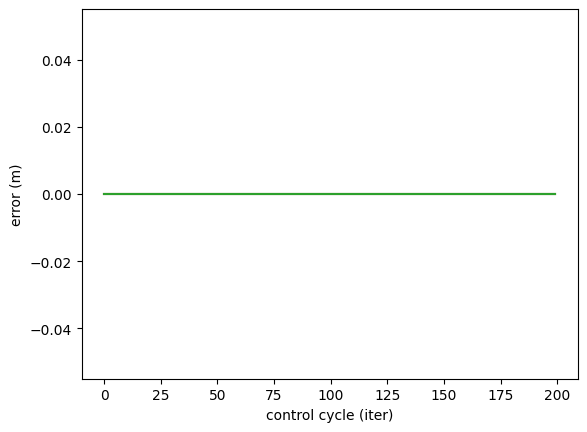

In [52]:
plt.plot(herr)
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)');

We can observe that each component of the error converges toward 0 following an exponential trajetory. The convergence is assymptotic. To accelerate the convergence, increase the gain of the control law ($v_q = - \lambda J^+ e$).

### Place the end effector (6D)
The previous control law brings the center of the effector toward the center of the goal frame. However, it does not control the orientation of the end effector: the axes of the two frames F_tool and F_goal do not converge.
We should now modify the control law to take into account the tool orientation. For that, we compute the error to be the SE(3) log of the displacement from the tool frame F_tool to the goal frame F_goal.

In [32]:
toolMgoal = oMtool.inverse()*oMgoal
tool_nu = pin.log(toolMgoal).vector

This error tool_nu is a 6d vector, that can be interpreted as the spatial (6d) velocity that should be applied during 1 second to displace the tool frame F_tool (placed at oMtool) to the goal frame F_goal (placed at oMgoal). This spatial velocity is expressed in the tool frame F_tool. It then corresponds to the 6D jacobian, that is also computed in the same frame F_tool.

Implement a second control law, following the same pattern than the previous control law. At each control cycle, you should:
* compute the displacement between F_tool and F_goal, denoted toolMgoal
* compute the 6D error using the SE(3) log tool_nu
* compute the 6D jacobian tool_Jtool
* compute the control law vq = pinv(J)*nu
* integrate the robot velocity vq during DT to get a new configuration q
* log the error by storing it in a list herr.

In [54]:
oMgoal.actInv?

In [59]:
%do_not_load tp3/generated/inverse_kinematics_6d_loop
q = q0.copy()
herr = []
for i in range(300):  # Integrate over 3 second of robot life

    # Run the algorithms that outputs values in robot.data
    #TODO

    # Placement from world frame o to frame f oMtool  
    #TODO

    # 6D error between the two frame
    #TODO

    # Get corresponding jacobian
    #TODO

    # Control law by least square
    vq = np.zeros(robot.nv) #TODO

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(tool_nu)

The tool frame F_tool converges toward the gooal frame F_goal: the center and the axes are finally aligned. The trajectory of the tool center is not a straight line, as the frame F_tool follows a "straight" line, not in R^3 but in SE(3).
We can also plot the error (assuming that herr is a list of the 6D errors herr).

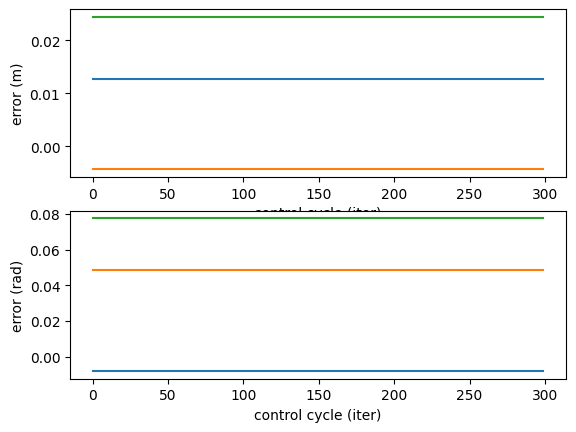

In [60]:
# %load tp3/generated/inverse_kinematics_plot
plt.subplot(211)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.subplot(212)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)');


### Inverse kinematics for two tasks
We have only yet controlled the robot with a single task (either the 3d position or the 6d placement errors). Let's see how to take into account a second task. Let's first introduce a second task. 

#### Introducing a second task: control the gaze
The robot has an additional frame named F_gaze, attached to the head and located 40 cm in front of the cameras. The task will be to position (3d) the center of this frame on an object of interest (a red ball).

In [67]:
# %load tp3/generated/control_head_robot
robot = loadTiago(addGazeFrame=True)
viz = MeshcatVisualizer(robot)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [68]:
# %load tp3/generated/control_head_gaze
IDX_GAZE = robot.model.getFrameId('framegaze')

# Add a small ball as a visual target to be reached by the robot
ball = np.array([ 1.2,0.5,1.1 ])
viz.addSphere('ball', .05, [ .8,.1,.5, .8] )
viz.applyConfiguration('ball', list(ball)+[0,0,0,1])
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',oMgoal)


In [69]:
viz.display(q0)
viz.viewer.jupyter_cell()

Controlling this point can be done by achieving a simple variation of the control law for positioning (3d) the robot tool.

In [70]:
# %load tp3/generated/control_head_gaze_loop
q = q0.copy()
herr = [] # Log the value of the error between gaze and ball.
# Loop on an inverse kinematics for 300 iterations.
for i in range(300):  # Integrate over 3 second of robot life

    # Run the algorithms that outputs values in robot.data
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Placement from world frame o to frame f oMgaze
    oMgaze = robot.data.oMf[IDX_GAZE]

    # 6D jacobian in local frame
    o_Jgaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE,pin.LOCAL_WORLD_ALIGNED)[:3,:]

    # vector from gaze to ball, in world frame
    o_GazeBall = oMgaze.translation-ball
    
    vq = -pinv(o_Jgaze3) @ o_GazeBall

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_GazeBall) 


#### Performing 2 tasks

We now have two tasks (e1,J1) controlling the tool and (e2,J2) controlling the gaze. 
If we try to solve them concurrently, they can end up being conflicting.

There is a trick that consists in solving the second task in the so-called null space 
of the first one. In our case, we want to only address the gaze task if it does not affect negatively affect 
the placement of the hand. One option to solve this issue is to ponderate the task by assigning different weights to the tasks. Another way is to try to stricly enforce the priority of one task over the other.

Intuitively, we can easily understand that some joints have no effect on task 1: the 2 head dofs have no influence on the position of the hand, so we are free to modify them. However, the prismatic joint and the mobile basis, if actuated, can enter in conflict with the tool task. Still, they can be actuated in such a way that they do not perturb the achievement of the first task while helping with the second one, although it is less trivial to see it.

The null space projector P of a jacobian J takes any vector $vq_k$ and projects it into a new vector such that
$$\nu = J v = J ( vq + P vq_k ),  \forall vq_k$$

In other words, we can change the velocity vector vq to a better suited one without modifying the effector velocity obtained (Remember that this is only true locally though, so $vq_k$ should have a small norm); 

The null space projector of $J_1$ can be computed using the pseudoinverse.
Following the control law performing task 1 and task 2 in the null space of task 1 is:
$$vq_1 = J_1^+ v_1^*$$
$$P_1 = I_{15} - J_1^+ J_1$$
$$vq_2 = vq_1 + (J_2 P_1)^+ ( v_2^* - J_2 vq_1)$$

We can now implement a control law solving the two tasks, i.e positioning the tool while controlling the gaze.

In [75]:
# %load tp3/generated/control_head_multi
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
herr2 = [] # Log the value of the error between gaze and ball.
# Loop on an inverse kinematics for 300 iterations.
for i in range(300):  # Integrate over 3 second of robot life

    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Gaze task
    oMgaze = robot.data.oMf[IDX_GAZE]
    o_Jgaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE,pin.LOCAL_WORLD_ALIGNED)[:3,:]
    o_GazeBall = oMgaze.translation-ball

    # Tool task
    oMtool = robot.data.oMf[IDX_TOOL]
    o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL,pin.LOCAL_WORLD_ALIGNED)[:3,:]
    o_TG = oMtool.translation-oMgoal.translation
    
    vq = -pinv(o_Jtool3) @ o_TG
    Ptool = np.eye(robot.nv)-pinv(o_Jtool3) @ o_Jtool3
    vq += pinv(o_Jgaze3 @ Ptool) @ (-o_GazeBall - o_Jgaze3 @ vq)

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG)
    herr2.append(o_GazeBall) 


(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(

A third task can be implemented as well by computing the null space of the two first tasks

In [72]:
Pgaze = Ptool - pinv(o_Jgaze3 @ Ptool) @ o_Jgaze3 @ Ptool

## Optional extra work

I. Implement the inverse kinematics loop using a constrained optimisation library. You can use quadprod to formulate the problem and enforce joint limits as hard constraints. If for some reason you can't use quadprog you can use slsqp, although it is a bit overkill: we have seen in class that the optimisation problem we want to solve is convex, so we don't need a non-linear solver for that.
You can also add a secondary cost that consists in computing a configuration close to the default configuration robot.q0 (ignoring the mobile base position in the cost). This is a called a postural task and is a classic way to ensure that the robot poses remain more or less natural.


II. Load an extra cube in the viewer to figure a table. First control the robot hand to reach an arbitrary point on the table (don't mind for the collision). Then implement a control law to control three tasks:
* the tool frame should be kept on the table (i.e. only the z component of the error matter, select only the 3rd row of the matrix).
* the gaze should be controlled to reach the position of a ball object positionned on the table.
* the center of the basis frame should reach a given target on the floor. For this task, only the x- and y- component of the task matter, select only the 2 first rows.
